In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

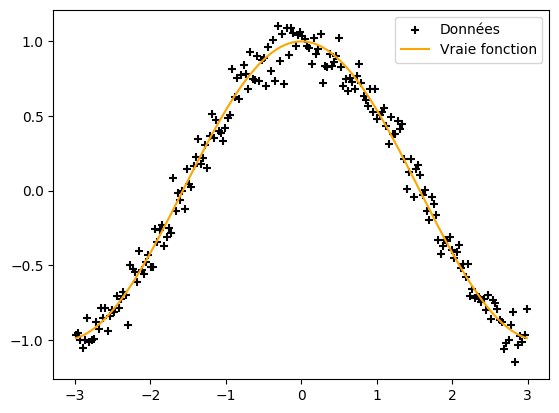

In [3]:
# Definition de la fonction de test
def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return np.cos(x) + epsilon

# Paramétrage des données d'entrainements
train_size = 200
# Le bruite
noise = 0.1

# Pour cos
xmin = -3
xmax = 3

zoomfig = 2
xminBig = xmin - zoomfig * (xmax - xmin)
xmaxBig = xmax + zoomfig * (xmax - xmin)

XBig = np.linspace(xminBig, xmaxBig, train_size *
                   (2*zoomfig + 1)).reshape(-1, 1)
X = XBig[train_size * zoomfig: train_size * zoomfig + train_size]
y = f(X, sigma=noise)
y_true = f(X, sigma=0.0)


# On affiche tout ça
plt.close()
plt.scatter(X, y, marker='+', label='Données', color = 'k')
plt.plot(X, y_true, label='Vraie fonction', color = 'orange')
plt.legend()
plt.show()

In [4]:
tX = torch.Tensor(X)
tXBig = torch.Tensor(XBig)
ty = torch.Tensor(y)

print("tX.shape : ", tX.shape)
print("tXBig.shape : ", tXBig.shape)
print("ty.shape : ", ty.shape)

tX.shape :  torch.Size([200, 1])
tXBig.shape :  torch.Size([1000, 1])
ty.shape :  torch.Size([200, 1])


In [5]:
class resNet(nn.Module) :
    def __init__(self, nin, nout) :
        super().__init__()
        self.nin = nin
        self.nout = nout
        self.Layer1 = nn.Linear(nin, 2)
        self.Layer2 = nn.Linear(2, nout)

    def forward(self, tX) :
        x = self.Layer1(tX)
        x = torch.tanh(x)
        
        x = self.Layer2(x)
        return x
    
    def zero_grad(self, set_to_none: bool = False) -> None:
        return super().zero_grad(set_to_none)
    
    def set_params(self, param_list):
        for p1, p2 in zip(list(self.parameters()), param_list) :
            p1.data = p2
        return self

In [6]:
def modelSize(ns):
    """ calcul le nombre de poids

    Parameters
    ----------
    ns : list
        liste des nombres de neurones par couches
    Returns
    -------
    int
        Le nombre de poids
    """
    return np.sum([(ns[i]+1)*ns[i+1] for i in range(len(ns)-1)])

In [7]:
nin = 1
nout = 1
myModel = resNet(nin, nout)

In [8]:
modelParamShapes = [p.data.shape for p in list(myModel.parameters())]

In [9]:
# Hypperparamètres
N = 5000
lmax = 6
P0 = 0.1
epsilon = 1e-3
fact = 0.1
sigma_0 = (lmax + 1) * fact
ns = [1, 2, 1]
activation = 'tanh'

# Temperature initial
Temp = 0.5

# Distance qui va être utiliser pour évaluer
# la dissimilarité entre les prédictions y_hat et la réponse y
pdist = 2

In [10]:
nw = modelSize(ns)

# distribution a priori
priorDist = torch.distributions.Normal(0, sigma_0)

In [11]:
thetas = [([torch.randn(shape) * sigma_0 for shape in modelParamShapes])
          for n in range(N)]

tYs = torch.concatenate(
    tuple([myModel.set_params(theta).forward(tX) for theta in thetas]), 1)

# Calcul la dissimilarité
rhos = (torch.cdist(tYs.t(), ty.t(), p=pdist) ** 2) / nw

#
rhoMin = []
rhoMax = []
epsJ = []
#
NP0 = int(N*P0)
invP0 = int(1/P0)
j = 0

# reglage de temperature
t = 0
TempCur = Temp
while (rhos[0, 0] > epsilon):

    # On trie les erreurs et on mets les poids dans
    # l'ordre croissant des érreurs qu'ils produisent
    rhos, indices = torch.sort(rhos, 0)

    rhoMin.append(str(np.float32(torch.min(rhos).detach())))
    rhoMax.append(str(np.float32(torch.max(rhos).detach())))

    thetas = [thetas[i] for i in list(indices[:, 0])]

    epsilon_j = rhos[NP0]
    epsJ.append(str(np.float32(epsilon_j[0].detach())))

    # Ici on a un échantillion de taille NP0 et on veut
    # en créer N à partir de cette échantillion en fesant
    # (invPO - 1) pas
    thetasSeeds = thetas[:NP0]
    rhoSeeds = rhos[:NP0]

    # Réglage de sigma_j
    sigma_j = sigma_0 - fact * lmax

    #
    thetas = thetasSeeds
    rhos = rhos[:NP0]

    for g in range(invP0 - 1):
        # resampling
        thetasResamples = [[(p + torch.randn(p.shape)*sigma_j)
                            for p in theta] for theta in thetasSeeds]
        # evaluation
        logPriorResamples = [
            [priorDist.log_prob(p) for p in theta] for theta in thetasResamples]
        logPriorSeeds = [
            [priorDist.log_prob(p) for p in theta] for theta in thetasSeeds]

        rj = [[torch.exp(- (p1 - p2)) for (p1, p2) in zip(l1, l2)]
              for (l1, l2) in zip(logPriorResamples, logPriorSeeds)]

        sj = [[(torch.minimum(t, torch.ones(t.shape)))
               for t in theta] for theta in rj]

        bj = [[(torch.rand(t.shape) <= t).float()
               for t in theta] for theta in sj]

        thetasNow = [[(bLoc * tRsLoc + (1 - bLoc) * tSLoc) for (tSLoc, tRsLoc, bLoc)
                      in zip(tS, tRs, b)] for (tS, tRs, b) in zip(thetasSeeds, thetasResamples, bj)]

        tYsNow = torch.concatenate(
            tuple([myModel.set_params(theta).forward(tX) for theta in thetasNow]), 1)
        rhoNow = (torch.cdist(tYsNow.t(), ty.t(), p=pdist) ** 2) / nw

        thetasVal = [(tNow) if (rhoN <= epsilon_j) else (tSeed)
                     for (tSeed, tNow, rhoN) in zip(thetasSeeds, thetasNow, rhoNow)]
        rhoVal = (rhoNow <= epsilon_j) * (rhoNow - rhoSeeds) + rhoSeeds

        # Mise à jour
        thetasSeeds = thetasVal
        thetas += thetasSeeds
        rhoSeeds = rhoVal
        rhos = torch.concatenate((rhos, rhoSeeds))

        # Réglage de la température
        TempCur = Temp / np.log(2 + t)
        t += 1

    j += 1
    if (j >= lmax):
        break


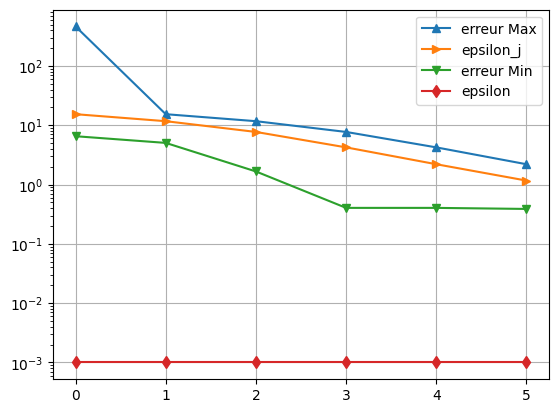

In [12]:
plt.figure()
plt.plot(np.float32(rhoMax), label = 'erreur Max', marker = '^')
plt.plot(np.float32(epsJ), label = 'epsilon_j', marker = '>')
plt.plot(np.float32(rhoMin), label = 'erreur Min', marker = 'v')
plt.plot(np.ones(len(rhoMin)) * epsilon, label = 'epsilon', marker = 'd')
plt.yscale('log')
plt.legend()
plt.grid('on')
plt.show()

In [13]:
y_hats = tYsNow = torch.concatenate(
            tuple([myModel.set_params(theta).forward(tX) for theta in thetas]), 1)

In [14]:
q2_5 = y_hats.quantile(0.025, 1).reshape(-1,1).detach().numpy()
q97_5 = y_hats.quantile(0.975, 1).reshape(-1,1).detach().numpy()
q25 = y_hats.quantile(0.25, 1).reshape(-1,1).detach().numpy()
q75 = y_hats.quantile(0.75, 1).reshape(-1,1).detach().numpy()
med = y_hats.quantile(0.5, 1).reshape(-1,1).detach().numpy()

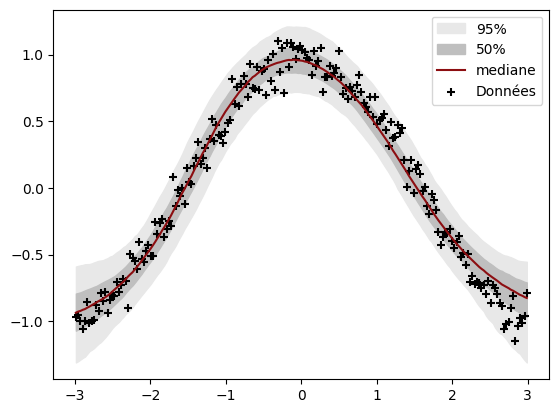

In [15]:
plt.clf()


plt.fill_between(tX.ravel().numpy(), q2_5[:, 0],
                 q97_5[:, 0], color="#e8e8e8", label='95%')

plt.fill_between(tX.ravel().numpy(), q25[:, 0], q75[:, 0],
                 color="#bfbfbf", label='50%')

plt.plot(tX, med, label="mediane", color="#8c0e11")

plt.scatter(tX,ty, marker='+', color='k', label='Données')

plt.legend()
plt.show()


In [16]:
idxList = 0
for theta in thetas : 
    idxParam = 0
    for p in theta :
        f = open("../data_prepare/cosParams/{}_{}.pt".format(idxList, idxParam), "wb")
        torch.save(p, f)
        f.close()
        idxParam += 1
    idxList += 1